# Importing libraries

In [1]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
import matplotlib.pyplot as plt
import pathlib, os, random
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import seaborn as sns

from pathlib import Path

from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization, Dropout , GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras.callbacks import Callback, EarlyStopping,ModelCheckpoint

# Classes

## Number of classes

In [3]:
train_path="Dataset/train/"
no_birds_classes = os.listdir(train_path)
len(no_birds_classes)

525

## Class names

In [4]:
data_dir = pathlib.Path("Dataset/train")
BirdClasses = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(BirdClasses)

['ABBOTTS BABBLER' 'ABBOTTS BOOBY' 'ABYSSINIAN GROUND HORNBILL'
 'AFRICAN CROWNED CRANE' 'AFRICAN EMERALD CUCKOO' 'AFRICAN FIREFINCH'
 'AFRICAN OYSTER CATCHER' 'AFRICAN PIED HORNBILL' 'AFRICAN PYGMY GOOSE'
 'ALBATROSS' 'ALBERTS TOWHEE' 'ALEXANDRINE PARAKEET' 'ALPINE CHOUGH'
 'ALTAMIRA YELLOWTHROAT' 'AMERICAN AVOCET' 'AMERICAN BITTERN'
 'AMERICAN COOT' 'AMERICAN DIPPER' 'AMERICAN FLAMINGO'
 'AMERICAN GOLDFINCH' 'AMERICAN KESTREL' 'AMERICAN PIPIT'
 'AMERICAN REDSTART' 'AMERICAN ROBIN' 'AMERICAN WIGEON'
 'AMETHYST WOODSTAR' 'ANDEAN GOOSE' 'ANDEAN LAPWING' 'ANDEAN SISKIN'
 'ANHINGA' 'ANIANIAU' 'ANNAS HUMMINGBIRD' 'ANTBIRD' 'ANTILLEAN EUPHONIA'
 'APAPANE' 'APOSTLEBIRD' 'ARARIPE MANAKIN' 'ASHY STORM PETREL'
 'ASHY THRUSHBIRD' 'ASIAN CRESTED IBIS' 'ASIAN DOLLARD BIRD'
 'ASIAN GREEN BEE EATER' 'ASIAN OPENBILL STORK' 'AUCKLAND SHAQ'
 'AUSTRAL CANASTERO' 'AUSTRALASIAN FIGBIRD' 'AVADAVAT' 'AZARAS SPINETAIL'
 'AZURE BREASTED PITTA' 'AZURE JAY' 'AZURE TANAGER' 'AZURE TIT'
 'BAIKAL TEAL' 'BALD EAGLE

In [5]:
# Get the top 20 labels
'''
label_counts = BirdClasses.value_counts()[:20]

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')
plt.title('Distribution of Top 20 Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()
'''

"\nlabel_counts = BirdClasses.value_counts()[:20]\n\nplt.figure(figsize=(20, 6))\nsns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')\nplt.title('Distribution of Top 20 Labels in Image Dataset', fontsize=16)\nplt.xlabel('Label', fontsize=14)\nplt.ylabel('Count', fontsize=14)\nplt.xticks(rotation=45)\nplt.show()\n"

# Visualising images

In [6]:
def view_random_image(target_dir, target_class):
  
  # setting up the image directory
  target_folder = target_dir + target_class

  #get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  #read image and plotting it
  img = plt.imread(target_folder + "/" + random_image[0] )
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  #print(f"Image shape: {img.shape}")
  
  return img

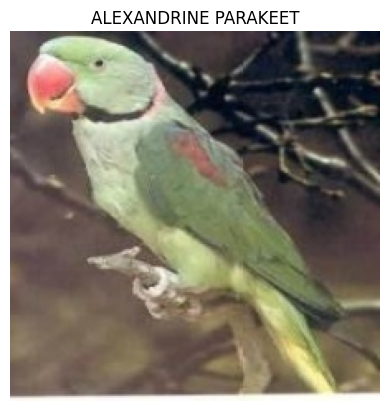

In [7]:
img = view_random_image(train_path,'ALEXANDRINE PARAKEET')

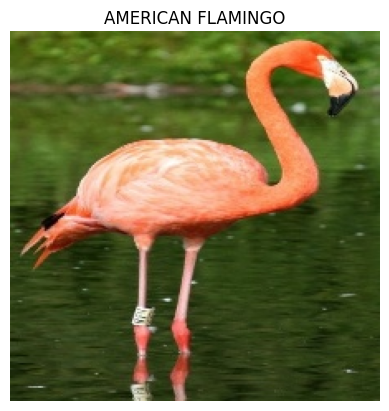

In [8]:
img = view_random_image(train_path,'AMERICAN FLAMINGO')

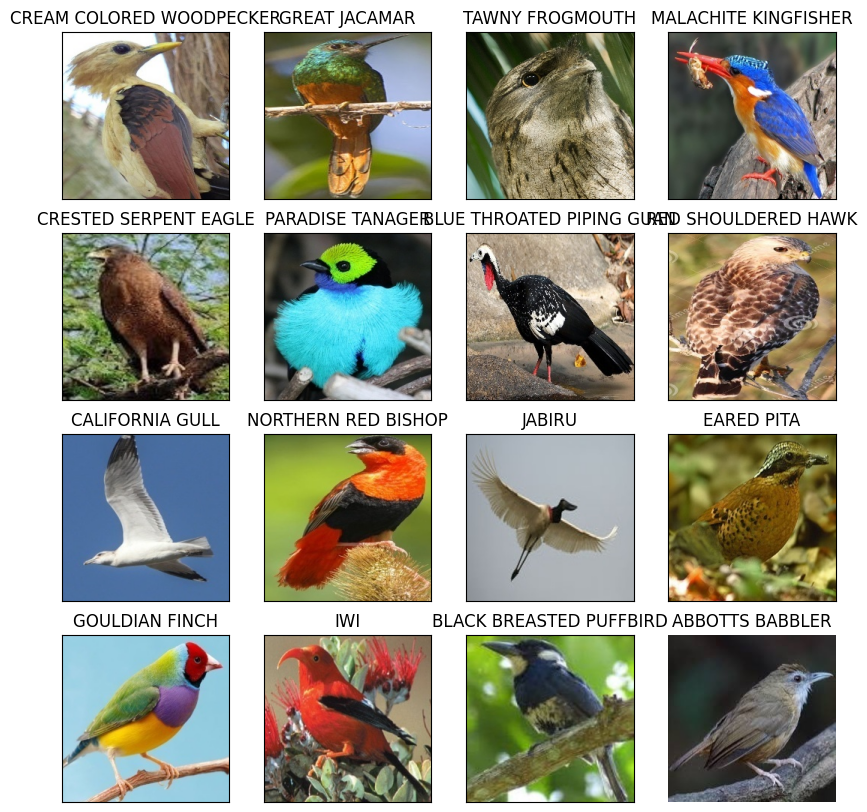

In [9]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

random_index = np.random.randint(0 , len(BirdClasses)-1 , 16)

for i, ax in enumerate(axes.flat):
    ax.imshow(view_random_image(train_path,BirdClasses[random_index[i]]))
    ax.set_title(BirdClasses[random_index[i]])

# Data preprocessing

In [10]:
train_dir = "Dataset/train/"
test_dir = "Dataset/test/"
val_dir = "Dataset/valid/"

In [11]:
from keras.applications.mobilenet_v2 import MobileNetV2

In [12]:
train_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory( train_dir , target_size=(224,224) , batch_size=32 , class_mode = "categorical" ,shuffle=True )

val_data = val_gen.flow_from_directory( val_dir , target_size=(224,224) , batch_size=32 , class_mode = "categorical" , shuffle=True )

test_data = test_gen.flow_from_directory( test_dir , target_size=(224,224) , batch_size=32 , class_mode = "categorical" ,shuffle=False )

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


# Mobilenet

## Prepairing the model

In [13]:
mobilenet = MobileNetV2( include_top=False , weights="imagenet" , input_shape=(224,224,3))

mobilenet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

## Fine-tuning

In [14]:
# Freezing all layers except the last 20 layers

mobilenet.trainable=True

for layer in mobilenet.layers[:-20]:
  layer.trainable=False

In [15]:
Model = Sequential([
    mobilenet,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256,activation='relu'),
    BatchNormalization(),
    Dense(525,activation='softmax')
])

Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                       

In [16]:
Model.compile( optimizer="adam", loss="categorical_crossentropy" , metrics=["accuracy"] )

In [17]:
callbacks = [EarlyStopping(monitor='val_accuracy' , patience=5 , restore_best_weights=True)]

In [18]:
history = Model.fit(train_data,epochs=15 , batch_size=32 ,steps_per_epoch = len(train_data)
,callbacks=callbacks ,workers=10,use_multiprocessing= True, validation_data=val_data,validation_steps = len(val_data))

Epoch 1/15


Exception in thread Thread-63 (_run):
Traceback (most recent call last):
  File "c:\Users\ritam\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\ritam\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\ritam\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\data_utils.py", line 829, in _run
    with closing(self.executor_fn(_SHARED_SEQUENCES)) as executor:
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ritam\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\data_utils.py", line 804, in pool_fn
    pool = get_pool_class(True)(
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ritam\AppData\Local\Programs\Python\Python311\Lib\multiprocessing\context.py", line 119, in Pool
    return Pool(processes, initializer, initargs, maxtasksperchild,
           ^^^^^^^^^^